# GAN Architecture with Generator & Discriminator using fake data

In [19]:
from numpy import expand_dims,zeros,ones,vstack
from numpy.random import randn, randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Dropout
from matplotlib import pyplot

## Discriminator definition

In [20]:
def disc_net(in_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64,(3,3),strides=(2,2), padding='same',input_shape=in_shape))
  #model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 128)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation= 'sigmoid'))
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss= 'binary_crossentropy' , optimizer=opt, metrics=[ 'accuracy' ])
  return model

def gen_net(latent_dim):
  model = Sequential()
  n_nodes = 128*7*7
  model.add(Dense(n_nodes,input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128)))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation= 'sigmoid' , padding= 'same' ))
  #model.add(Conv2D(128,(4,4), activation='sigmoid',padding='same'))
  return model

In [21]:
def gan(gen,disc):
  disc.trainable = False
  model = Sequential()
  model.add(gen)
  model.add(disc)
  print("----------------GAN Arch -----------")
  model.summary()
  opt = Adam(learning_rate=0.0002,beta_1 = 0.5)
  model.compile(loss='binary_crossentropy',optimizer = opt)
  return model

In [24]:
def load_samples():
  (trainX,_), (_,_) = load_data()
  X = expand_dims(trainX,axis=-1)
  X = X.astype('float32')
  X = X / 255.0
  return X
def real_gen(dataset,n_samples):
  ri = randint(0,dataset.shape[0],n_samples)
  X = dataset[ri]
  y = ones((n_samples,1))
  return X, y
def latent_gen(latent_dim, n_samples):
  x = randn(latent_dim*n_samples)
  return x.reshape(n_samples, latent_dim)
def fake_gen(gen, latent_dim, n_samples):
  x = latent_gen(latent_dim, n_samples)
  X = gen.predict(x)
  y = zeros((n_samples,1))
  return X,y

def plot_save(examples, epoch, n=10):
  for i in range(n*n):
    pyplot.subplot(n,n,1+i)
    pyplot.axis('off')
    pyplot.imshow(examples[i,:,:,0],cmap='gray_r')
    filename = 'gen_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()
def performance(epoch,gen,disc,dataset,latent_dim,n_samples=100):
  X_real, y_real = real_gen(dataset,n_samples)
  _,acc_real = disc.evaluate(X_real,y_real,verbose =0) # evaluate disc on fake exampels
  x_fake, y_fake = fake_gen(gen,latent_dim,n_samples)
  _, acc_fake = disc.evaluate(x_fake,y_fake,verbose = 0)
  print('> Real Acc: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  plot_save(x_fake,epoch)
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  gen.save(filename)

In [23]:
def train(gen,disc,gan,dataset,latent_dim,n_epochs = 100,n_batch = 256):
  bat = int(dataset.shape[0] / n_batch) # Batch per iterating epoch
  split = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(bat):
      x_real, y_real = real_gen(dataset,split)
      x_fake, y_fake = fake_gen(gen,latent_dim,split)
      print()
      print("shape of x_real", x_real.shape)
      print("shape of x_fake", x_fake.shape)
      print("shape of y_real", y_real.shape)
      print("shape of y_fake", y_fake.shape)
      X, y = vstack((x_real,x_fake)) , vstack((y_real,y_fake))
      d_loss, _ = disc.train_on_batch(X, y) # disc weights
      X_gan = latent_gen(latent_dim,n_batch)
      y_gan = ones((n_batch,1))
      g_loss = gan.train_on_batch(X_gan,y_gan)    # discriminator error updates the generator
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat, d_loss, g_loss))
    if (i+1) % 10 == 0:
      performance(i,gen,disc,dataset,latent_dim)

latent_dim = 100
disc = disc_net()
gen = gen_net(latent_dim)
print("-------------------------Gen arch------------")
print(gen.summary())
print()
print("-------------------------Disc arch------------")
print(disc.summary())
gan = gan(gen,disc)
dataset = load_samples()
train(gen,disc,gan,dataset,latent_dim)

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>7, 223/234, d=0.688, g=0.711
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>7, 224/234, d=0.681, g=0.715
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>7, 225/234, d=0.683, g=0.713
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>7, 226/234, d=0.685, g=0.722
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fak

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>17, 223/234, d=0.688, g=0.719
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>17, 224/234, d=0.679, g=0.704
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>17, 225/234, d=0.687, g=0.685
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>17, 226/234, d=0.686, g=0.682
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>27, 223/234, d=0.686, g=0.717
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>27, 224/234, d=0.686, g=0.736
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>27, 225/234, d=0.686, g=0.746
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>27, 226/234, d=0.677, g=0.733
4/4 [==============================] - 0s 5ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>37, 223/234, d=0.671, g=0.719
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>37, 224/234, d=0.683, g=0.707
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>37, 225/234, d=0.687, g=0.699
4/4 [==============================] - 0s 5ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>37, 226/234, d=0.685, g=0.718
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>47, 223/234, d=0.685, g=0.739
4/4 [==============================] - 0s 3ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>47, 224/234, d=0.691, g=0.704
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>47, 225/234, d=0.690, g=0.671
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>47, 226/234, d=0.684, g=0.671
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 6ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>57, 223/234, d=0.697, g=0.729
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>57, 224/234, d=0.700, g=0.717
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>57, 225/234, d=0.691, g=0.702
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>57, 226/234, d=0.698, g=0.689
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 8ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>67, 223/234, d=0.694, g=0.747
4/4 [==============================] - 0s 7ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>67, 224/234, d=0.697, g=0.702
4/4 [==============================] - 0s 8ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>67, 225/234, d=0.687, g=0.681
4/4 [==============================] - 0s 10ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>67, 226/234, d=0.688, g=0.698
4/4 [==============================] - 0s 5ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of 

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 5ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>77, 223/234, d=0.687, g=0.744
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>77, 224/234, d=0.694, g=0.722
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>77, 225/234, d=0.684, g=0.705
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>77, 226/234, d=0.685, g=0.692
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>87, 223/234, d=0.683, g=0.687
4/4 [==============================] - 0s 3ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>87, 224/234, d=0.693, g=0.700
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>87, 225/234, d=0.697, g=0.714
4/4 [==============================] - 0s 5ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>87, 226/234, d=0.694, g=0.704
4/4 [==============================] - 0s 11ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of 

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 3ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>97, 223/234, d=0.685, g=0.698
4/4 [==============================] - 0s 5ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>97, 224/234, d=0.681, g=0.681
4/4 [==============================] - 0s 5ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>97, 225/234, d=0.692, g=0.693
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y_fake (128, 1)
>97, 226/234, d=0.692, g=0.722
4/4 [==============================] - 0s 4ms/step

shape of x_real (128, 28, 28, 1)
shape of x_fake (128, 28, 28, 1)
shape of y_real (128, 1)
shape of y

1/1 [==============================] - 0s 187ms/step


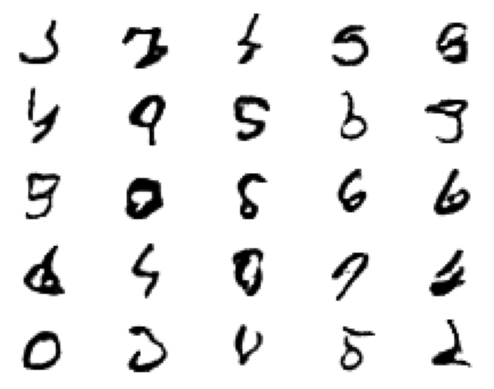

In [28]:
from keras.models import load_model


def plot_save_v2(ex,n):
  for i in range(n*n):
    pyplot.subplot(n,n,1+i)
    pyplot.axis('off')
    pyplot.imshow(ex[i, :, :, 0],cmap = 'gray_r')
  pyplot.show()

model = load_model('generator_model_100.h5')
latent_points = latent_gen(100, 25)
X = model.predict(latent_points)
plot_save_v2(X, 5)
